###### This file runs a GCN on a 1 drone 1 goal probe environemnt of size 3x3. It features heterogen graph nodes and state-space normalization

In [1]:
import numpy as np
from numpy.random import choice, randint, rand, uniform

import pdb

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils.random import erdos_renyi_graph
from torch_geometric.utils import to_dense_adj, to_networkx, to_undirected

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import networkx as nx
import gym
from gym.spaces import Box, MultiDiscrete

from collections import namedtuple
from copy import copy, deepcopy
from typing import Optional
from enum import Enum, IntEnum
import sys
sys.path.append('/home/victorialena/rlkit')

import rlkit
from path_collector import MdpPathCollector

from any_replay_buffer import anyReplayBuffer

In [2]:
import time
start_time = time.time()

### env

In [3]:
device = 'cpu' #torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

In [4]:
sysconfig = namedtuple("sysconfig", 
                       ['maxX', 'maxY', 'goal_reward'], 
                       defaults=[5, 5, 1.])

In [5]:
actions = namedtuple("actions", 
                    ['right', 'left', 'up', 'down', 'noop'], 
                    defaults=[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)])
action = actions()
a2vecmap = torch.Tensor([[1., 0.],
                         [-1, 0.],
                         [0., 1.],
                         [0, -1.],
                         [0., 0.]]).to(device)

In [6]:
def fully_connect_graph(n_drones):
    """ Connect the graph s.t. all drones are interconnected and each goal connects to all drones. """
    
    idx = torch.combinations(torch.arange(n_drones+1), r=2)
    return to_undirected(idx.t(), num_nodes=n_drones+1)

In [32]:
class droneDeliveryProbe(gym.Env):
    """
    ### Description
    
    ### Action Space
    Each agent in the scene can move R or L or not at all.
    
    ### State Space
    The state is defined as an arbitrary input array of positions of n drones, appended by the location
    of the goal region.
    
    ### Rewards
    The reward of +1 is given to the system for each drone reaching the goal region.
    
    ### Starting State
    Randomly initilized input array.
    
    ### Episode Termination
    When all drones have reached the goal region.
    
    ### Arguments
    No additional arguments are currently supported.
    """

    def __init__(self, n=1, device='cpu'):
        self.config = sysconfig()
        self.ndrones = n
        
        self.aspace = MultiDiscrete([len(action)]*self.ndrones)
        self.sspace = MultiDiscrete([self.config.maxX, self.config.maxY, 2])
        self.state = None
        
        self._device = device
         
    def get_distances(self):
        return (self.state.x[-1, :-1]-self.state.x[:-1, :-1]).norm(p=1, dim=1)
    
    def get_size(self):
        return torch.Tensor([self.config.maxX, self.config.maxY, 2])
        
    def reward(self, a):
        return (self.get_distances() == 0).all().float().item()
                        
    def step(self, a):
        err_msg = f"{a!r} ({type(a)}) is not a valid action."
        assert self.aspace.contains(a), err_msg
        
        reward = self.reward(a)
        a = a2vecmap[a]
        done = (self.get_distances() == 0).all().item()   
    
        self.state.x[:-1, :-1] = (self.state.x[:-1, :-1]+a).clamp(min=0, max=self.config.maxX)
        
        return deepcopy(self.state), deepcopy(reward), deepcopy(done), {}

    def reset(self, seed: Optional[int] = None):
        if not seed == None:
            super().reset(seed=seed)
            
        x = torch.Tensor(np.stack([self.sspace.sample() for _ in range(self.ndrones+1)]))
        # reset the state flags: +1 agent, -1 goal
        x[:, -1] = 1
        x[-1, -1] = -1
        
        edge_index = fully_connect_graph(self.ndrones)
        self.state = Data(x=x, edge_index=edge_index).to(device)
        
        return deepcopy(self.state)

    def render(self, s = None):
        if not s:
            s = self.state
        g = torch_geometric.utils.to_networkx(s, to_undirected=False)
        colors = np.array(['green']*self.ndrones+['yellow'])
        pos = {i: x[:2].numpy() for i, x in enumerate(self.state.x)}
        nx.draw(g, pos=pos, node_color=colors)
    
    def seed(self, n: int):
        super().seed(n)
        self.aspace.seed(n)
        self.sspace.seed(n)
        
    def to(self, device):
        self._device = device
        if self.state:
            self.state = self.state.to(device)

In [34]:
env = droneDeliveryProbe(1, device=device)
x = env.reset()

### Model

In [9]:
from collections import OrderedDict

from torch.nn import Linear, ReLU, Softmax
import torch.nn.functional as F
from torch_geometric.nn import Sequential, GCNConv, SAGEConv
        
class droneDeliveryModel(nn.Module):
    
    def __init__(self, c_in, c_out, c_hidden=64, bounds=None, **kwargs):
        
        super().__init__()
        
        self.model = Sequential('x, edge_index', [
            (SAGEConv(c_in, c_hidden), 'x, edge_index -> x'),
            ReLU(inplace=True),
            (SAGEConv(c_hidden, c_hidden), 'x, edge_index -> x'),
            ReLU(inplace=True),
            (SAGEConv(c_hidden, c_hidden), 'x, edge_index -> x'),
            ReLU(inplace=True),
            Linear(c_hidden, c_out),
#             nn.Softmax(dim=-1) # no freaking softmax
        ])
        
        self._device = 'cpu'
        self._upper_bound = bounds

    def forward(self, x):
        y = x.x
        if self._upper_bound is not None:
            y = y.div(self._upper_bound-1)
        return self.model(y, x.edge_index)[:-1]
    
    def to(self, device):
        super().to(device)
        self._device = device
        if self._upper_bound is not None:
            self._upper_bound = self._upper_bound.to(device)

In [10]:
in_channels, out_channels = 2+1, len(action)

### RL 

In [11]:
max_len = env.config.maxX + env.config.maxY - 1

In [12]:
def pick(x):
    probs = np.array([x[0]>0, x[0]<0, x[1]>0, x[1]<0, x[1]==x[0]==0], dtype=int)
    return np.random.choice(action, p=probs/sum(probs))

In [13]:
from rlkit.policies.base import Policy

# pick = lambda x: np.random.choice(action, p=x/sum(x) if sum(x) != 0 else None)
# pick = lambda x: np.random.choice(action, p=np.array([x[0]>0, x[0]<0, x[1]>0, x[1]<0, x[1]==x[0]==0], dtype=int))

class sysRolloutPolicy(nn.Module, Policy):
    def __init__(self):
        super().__init__()

    def get_action(self, obs):
        dis = (obs.x[-1] - obs.x[:-1]) #cpu().numpy()
#         p = np.array([dis[0] > 0, dis[0] < 0, dis[1] > 0, dis[1] < 0, dis[1]==dis[0]==0], dtype=int)
        return [pick(d) for d in dis], {}
    
class argmaxDiscretePolicy(nn.Module, Policy):
    def __init__(self, qf, dim=1):
        super().__init__()
        self.qf = qf
        self.dim = dim

    def get_action(self, obs):
        q_values = self.qf(obs)
        return q_values.cpu().detach().numpy().argmax(self.dim), {}

# # redundant code - clean this up
# class epsilonGreedyPolicy(nn.Module, Policy):
#     def __init__(self, qf, space, eps=0.1, dim=1):
#         super().__init__()
#         self.qf = qf
#         self.aspace = space
        
#         self.eps = eps
#         self.dim = dim

#     def get_action(self, obs):
#         if rand() < self.eps:
#             return self.aspace.sample(), {}
#         q_values = self.qf(obs)
#         return q_values.cpu().detach().numpy().argmax(self.dim), {}

# redundant code - clean this up
class epsilonGreedyPolicy(nn.Module, Policy):
    def __init__(self, qf, space, eps=0.1, dim=1, sim_annealing_fac=1.0):
        super().__init__()
        self.qf = qf
        self.aspace = space
        
        self.eps = eps
        self.dim = dim
        self.saf = sim_annealing_fac
        
    def simulated_annealing(self):
        self.eps *= self.saf

    def get_action(self, obs):
        if rand() < self.eps:
            return self.aspace.sample(), {}
        q_values = self.qf(obs)
        return q_values.cpu().detach().numpy().argmax(self.dim), {}

In [14]:
def mean_reward_per_traj(paths):
    return np.mean([np.sum(p['rewards']) for p in paths])

def mean_reward(paths):
    return np.hstack([p['rewards'] for p in paths]).mean()

In [15]:
example_policy = sysRolloutPolicy() 
path_collector = MdpPathCollector(env, example_policy)
paths = path_collector.collect_new_paths(100, max_len, False)
expected_heuristic_pt = mean_reward_per_traj(paths)
print("Expected reward (per traj):", expected_heuristic_pt)
expected_heuristic = mean_reward(paths)
print("Expected reward (per step):", expected_heuristic, '\n')

idx = np.random.randint(100)
for s, a, r, t in zip(paths[idx]['observations'], paths[idx]['actions'], 
                      paths[idx]['rewards'], paths[idx]['terminals']):
    print('\n', s)
    print(a)
    print(r)
    print(t)

Expected reward (per traj): 1.0
Expected reward (per step): 0.2331002331002331 


 Data(x=[2, 3], edge_index=[2, 2])
[3]
0.0
False

 Data(x=[2, 3], edge_index=[2, 2])
[1]
0.0
False

 Data(x=[2, 3], edge_index=[2, 2])
[3]
0.0
False

 Data(x=[2, 3], edge_index=[2, 2])
[3]
0.0
False

 Data(x=[2, 3], edge_index=[2, 2])
[4]
1.0
True


In [16]:
qf = droneDeliveryModel(in_channels, out_channels, 8)
qf.to(device)

In [17]:
example_policy = argmaxDiscretePolicy(qf) 
path_collector = MdpPathCollector(env, example_policy)
paths = path_collector.collect_new_paths(100, max_len, False)
expected_random_pt =  mean_reward_per_traj(paths)
print("Expected reward (per traj):", expected_random_pt)
expected_random = mean_reward(paths)
print("Expected reward (per step):", expected_random)

idx = np.random.randint(100)
for s, a, r, t in zip(paths[idx]['observations'], paths[idx]['actions'], 
                      paths[idx]['rewards'], paths[idx]['terminals']):
    print('\n', s)
    print(a)
    print(r)
    print(t)
    

Expected reward (per traj): 0.08
Expected reward (per step): 0.009445100354191263

 Data(x=[2, 3], edge_index=[2, 2])
[2]
1.0
True


#### train

In [18]:
RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
env.seed(RANDOM_SEED)

In [19]:
qf = droneDeliveryModel(in_channels, out_channels, 32, bounds=env.get_size())
qf.to(device)

target_qf = droneDeliveryModel(in_channels, out_channels, 32, bounds=env.get_size())
target_qf.to(device)

In [20]:
qf_criterion = nn.MSELoss()
eval_policy = argmaxDiscretePolicy(qf)
# expl_policy = sysRolloutPolicy()
# expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=.1)
expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=.5, sim_annealing_fac=.9)

In [21]:
expl_path_collector = MdpPathCollector(env, expl_policy) 
eval_path_collector = MdpPathCollector(env, eval_policy)
replay_buffer = anyReplayBuffer(1000, prioritized=True) # 256
optimizer = Adam(qf.parameters(), lr=5E-3)

In [22]:
n_epoch = 15
n_iter = 100
batch_size = 256 #128
n_samples = 256

loss = []
avg_r_train = []
avg_r_test = []

for i in range(n_epoch):
    qf.train(False)
    paths = eval_path_collector.collect_new_paths(128, max_len, False)
    avg_r_test.append(mean_reward_per_traj(paths))
    
    paths = expl_path_collector.collect_new_paths(n_samples, max_len, False)
    replay_buffer.add_paths(paths) # does this mmake any sense at all ?
    
    qf.train(True)
    if n_epoch > 0:
        expl_path_collector._policy.simulated_annealing()
    for _ in range(n_iter):
        batch = replay_buffer.random_batch(batch_size)
        rewards = torch.Tensor(batch['rewards']).unsqueeze(-1).to(device)
        terminals = torch.Tensor(batch['terminals']).unsqueeze(-1).to(device)
        actions = torch.Tensor(batch['actions']).to(device)

        obs = batch['observations']
        next_obs = batch['next_observations']
                
        out = torch.stack(list(map(target_qf, next_obs)), axis=0)         
        target_q_values = out.max(-1, keepdims=False).values
        y_target = rewards + (1. - terminals) * 0.90 * target_q_values 
        out = torch.stack(list(map(qf, obs)), axis=0)
               
        actions_one_hot = F.one_hot(actions.to(torch.int64), len(action))
        y_pred = torch.sum(out * actions_one_hot, dim=-1, keepdim=False)
        qf_loss = qf_criterion(y_pred, y_target)
        
        loss.append(qf_loss.item())
        avg_r_train.append(rewards.mean().item())
        
        optimizer.zero_grad() 
        qf_loss.backward()
        optimizer.step()
        
#     print(qf.state_dict().items())
    
    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    print("iter ", i+1, " -> loss: ", np.mean(loss[-n_iter:]),
          ", rewards: (train) ", np.mean(avg_r_train[-n_iter:]),
          ", (test) ", avg_r_test[-1])

iter  1  -> loss:  0.012346086765173823 , rewards: (train)  0.0201953125 , (test)  0.125
iter  2  -> loss:  0.010664512463845312 , rewards: (train)  0.0395703125 , (test)  0.0859375
iter  3  -> loss:  0.0032453284034272656 , rewards: (train)  0.0571875 , (test)  0.21875
iter  4  -> loss:  0.008051351255271583 , rewards: (train)  0.1953125 , (test)  0.546875
iter  5  -> loss:  0.003292089548194781 , rewards: (train)  0.299609375 , (test)  0.9140625
iter  6  -> loss:  0.0020188888593111187 , rewards: (train)  0.2823828125 , (test)  0.90625
iter  7  -> loss:  0.0012631851446349173 , rewards: (train)  0.3609375 , (test)  0.921875
iter  8  -> loss:  0.0008649655000772328 , rewards: (train)  0.3570703125 , (test)  0.953125
iter  9  -> loss:  0.0004760400309169199 , rewards: (train)  0.3863671875 , (test)  1.0
iter  10  -> loss:  0.0003896082961000502 , rewards: (train)  0.3931640625 , (test)  0.9765625
iter  11  -> loss:  0.00032623775419779124 , rewards: (train)  0.376015625 , (test)  1.0
i

In [23]:
print("This eval took me ", time.time() - start_time, " seconds. Thanks for waiting :)")

This eval took me  502.2989065647125  seconds. Thanks for waiting :)


In [24]:
import matplotlib.pyplot as plt

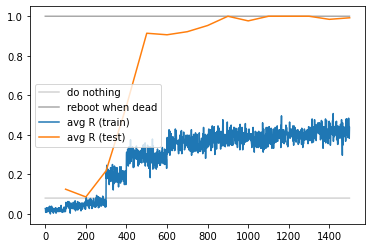

In [25]:
plt.plot(np.arange(n_iter*n_epoch), [expected_random_pt]*(n_iter*n_epoch), label = "do nothing", color='lightgray')
plt.plot(np.arange(n_iter*n_epoch), [expected_heuristic_pt]*(n_iter*n_epoch), label = "reboot when dead",  color='darkgray')

plt.plot(np.arange(n_iter*n_epoch), avg_r_train, label = "avg R (train)")
plt.plot(np.arange(n_iter, n_iter*n_epoch+1, step=n_iter), avg_r_test, label = "avg R (test)")
plt.legend()

# plt.savefig('training_log.png', dpi=300)

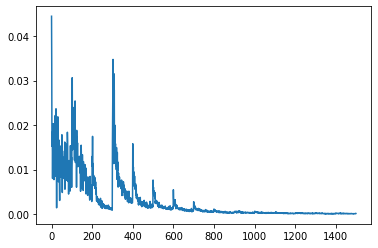

In [26]:
plt.plot(loss)

### curricul learning test

```python
torch.save(qf.state_dict(), "qf_stat1_chk.pt")
```

In [ ]:
RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
env.seed(RANDOM_SEED)

In [37]:
env = droneDeliveryProbe(2, device=device)
x = env.reset()

In [38]:
qf_criterion = nn.MSELoss()
eval_policy = argmaxDiscretePolicy(qf)
expl_policy = epsilonGreedyPolicy(qf, env.aspace, eps=.1)

expl_path_collector = MdpPathCollector(env, expl_policy) 
eval_path_collector = MdpPathCollector(env, eval_policy)
replay_buffer = anyReplayBuffer(1000, prioritized=True) # 256
# optimizer = Adam(qf.parameters(), lr=5E-3)

In [39]:
n_epoch = 20
n_iter = 100
batch_size = 256 #128
n_samples = 256

loss = []
avg_r_train = []
avg_r_test = []

for i in range(n_epoch):
    qf.train(False)
    paths = eval_path_collector.collect_new_paths(128, max_len, False)
    avg_r_test.append(mean_reward_per_traj(paths))
    
    paths = expl_path_collector.collect_new_paths(n_samples, max_len, False)
    replay_buffer.add_paths(paths) # does this mmake any sense at all ?
    
    qf.train(True)
    if n_epoch > 0:
        expl_path_collector._policy.simulated_annealing()
    for _ in range(n_iter):
        batch = replay_buffer.random_batch(batch_size)
        rewards = torch.Tensor(batch['rewards']).unsqueeze(-1).to(device)
        terminals = torch.Tensor(batch['terminals']).unsqueeze(-1).to(device)
        actions = torch.Tensor(batch['actions']).to(device)

        obs = batch['observations']
        next_obs = batch['next_observations']
                
        out = torch.stack(list(map(target_qf, next_obs)), axis=0)         
        target_q_values = out.max(-1, keepdims=False).values
        y_target = rewards + (1. - terminals) * 0.90 * target_q_values 
        out = torch.stack(list(map(qf, obs)), axis=0)
               
        actions_one_hot = F.one_hot(actions.to(torch.int64), len(action))
        y_pred = torch.sum(out * actions_one_hot, dim=-1, keepdim=False)
        qf_loss = qf_criterion(y_pred, y_target)
        
        loss.append(qf_loss.item())
        avg_r_train.append(rewards.mean().item())
        
        optimizer.zero_grad() 
        qf_loss.backward()
        optimizer.step()
        
#     print(qf.state_dict().items())
    
    target_qf.load_state_dict(deepcopy(qf.state_dict()))
    print("iter ", i+1, " -> loss: ", np.mean(loss[-n_iter:]),
          ", rewards: (train) ", np.mean(avg_r_train[-n_iter:]),
          ", (test) ", avg_r_test[-1])

iter  1  -> loss:  0.0019866787240607666 , rewards: (train)  0.0076953125 , (test)  0.03125
iter  2  -> loss:  0.0026824874815065416 , rewards: (train)  0.0134765625 , (test)  0.0546875
iter  3  -> loss:  0.001265185091760941 , rewards: (train)  0.005390625 , (test)  0.0234375
iter  4  -> loss:  0.002249628988211043 , rewards: (train)  0.031875 , (test)  0.140625
iter  5  -> loss:  0.004146127826534212 , rewards: (train)  0.0551953125 , (test)  0.1953125
iter  6  -> loss:  0.002303166355704889 , rewards: (train)  0.0417578125 , (test)  0.1484375
iter  7  -> loss:  0.002832158247474581 , rewards: (train)  0.040078125 , (test)  0.2421875
iter  8  -> loss:  0.0017070990765932948 , rewards: (train)  0.016484375 , (test)  0.0078125
iter  9  -> loss:  0.001854901232291013 , rewards: (train)  0.0244921875 , (test)  0.0625
iter  10  -> loss:  0.0019340386026306079 , rewards: (train)  0.0269921875 , (test)  0.125
iter  11  -> loss:  0.005165544738993048 , rewards: (train)  0.11203125 , (test)  

```python 
qf.train(False);

x = Data(x=torch.Tensor([[1, 0], [1, 1]]), 
         edge_index=torch.eye(2, dtype=torch.int64))
qf(x.to(device))
```